<a href="https://colab.research.google.com/github/ab2gbl/Master2/blob/main/MLCI/TP/MLCI_tp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.saving import save_model,load_model


In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist

# Charger le dataset MNIST
(x_train, _), (x_test, _) = mnist.load_data()

# Normaliser les images (mettre les valeurs entre 0 et 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Ajouter une dimension pour les canaux (requis pour Keras et CNN)
x_train = np.expand_dims(x_train, axis=-1)  # Shape devient (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape devient (10000, 28, 28, 1)

print("Forme des données normalisées :", x_train.shape, x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Forme des données normalisées : (60000, 28, 28, 1) (10000, 28, 28, 1)


# noise functions

In [ ]:
def Bruit_Gaussien(images, mean=0, var=0.3):
    noise = np.random.normal(mean, var**0.5, images.shape)
    return np.clip(images + noise, 0.0, 1.0)


In [ ]:
def Bruit_SP(images, prob=0.05):
    noisy_images = images.copy()
    for image in noisy_images:
        salt = np.random.rand(*image.shape) < prob / 2
        pepper = np.random.rand(*image.shape) < prob / 2
        image[salt] = 1.0
        image[pepper] = 0.0
    return noisy_images


In [ ]:
def Bruit_Poisson(images):
    noise = np.random.poisson(images * 255.0) / 255.0
    return np.clip(images + noise, 0.0, 1.0)


In [ ]:
def Bruit_Speckle(images, mean=0, var=0.1):
    noise = np.random.normal(mean, var**0.5, images.shape) * images
    return np.clip(images + noise, 0.0, 1.0)


# encoder

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D

'''
encoder
layer     | output          | param
input     | (None.28,28,1)  |  0
conv2d    | (None,14,14,32) |  320
conv2d_1  | (None, 7, 7, 64)|  18496
flatten   | (None,3136)     |  0
dense     | (None,16)       |  50192
dense_1   | (None,10)       |  1
'''
# Encoder architecture
input_img = Input(shape=(28, 28, 1))  # Input layer
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(input_img)  # Downsample to (14, 14, 32)
x = Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)          # Downsample to (7, 7, 64)
x = Flatten()(x)                                                                     # Flatten to (3136)
x = Dense(16, activation='relu')(x)                                                  # Dense layer with 16 units
encoded = Dense(10, activation='relu')(x)                                            # Compressed representation

encoder = Model(input_img, encoded, name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          50,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,178 (270.23 KB)

 Trainable params: 69,178 (270.23 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Reshape

'''
decoder
layer               | output              | param
input_1             | (None, 10)          | 0
dense_2             | (None, 3136)        | 34496
reshape             | (None, 7, 7, 64)    | 0
conv2d_transpose    | (None, 14, 14, 64)  | 36928
conv2d_transpose_1  | (None, 28, 28, 32)  | 18464
conv2d_transpose_2  | (None, 28, 28, 1)   | 289
'''
# Decoder architecture
decoder_input = Input(shape=(10,))                              # Input layer
x = Dense(3136, activation='relu')(decoder_input)               # Expand to match flattened dimensions
x = Reshape((7, 7, 64))(x)                                      # Reshape to (7, 7, 64)
x = Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)  # Upsample to (14, 14, 64)
x = Conv2DTranspose(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)  # Upsample to (28, 28, 32)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)         # Final output (28, 28, 1)

decoder = Model(decoder_input, decoded, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3136)                │          34,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Autoencoder combines the encoder and decoder
autoencoder_input = Input(shape=(28, 28, 1))  # Input image
encoded_output = encoder(autoencoder_input)   # Pass through encoder
decoded_output = decoder(encoded_output)      # Pass through decoder

autoencoder = Model(autoencoder_input, decoded_output, name="autoencoder")
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 10)                  │          69,178 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          90,177 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,355 (622.48 KB)

 Trainable params: 159,355 (622.48 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Appliquer le bruit Gaussien (exemple)
x_train_noisy = Bruit_Gaussien(x_train)
x_test_noisy = Bruit_Gaussien(x_test)

# Shuffle des données
from sklearn.utils import shuffle
x_train_noisy, x_train = shuffle(x_train_noisy, x_train)


In [ ]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 92s 191ms/step - loss: 0.3382 - val_loss: 0.2021
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 180ms/step - loss: 0.1964 - val_loss: 0.1830
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 89s 191ms/step - loss: 0.1815 - val_loss: 0.1768
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 189ms/step - loss: 0.1765 - val_loss: 0.1738
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 191ms/step - loss: 0.1737 - val_loss: 0.1723
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 193ms/step - loss: 0.1714 - val_loss: 0.1709
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 187ms/step - loss: 0.1702 - val_loss: 0.1700
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 186ms/step - loss: 0.1691 - val_loss: 0.1689
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 186ms/step - loss: 0.1683 - val_loss: 0.1693
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 186ms/step - loss: 0.1680 - val_loss: 0.1686
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 187ms/step - loss: 0.1671 - val_loss: 0.1677
Epoch 12/30


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


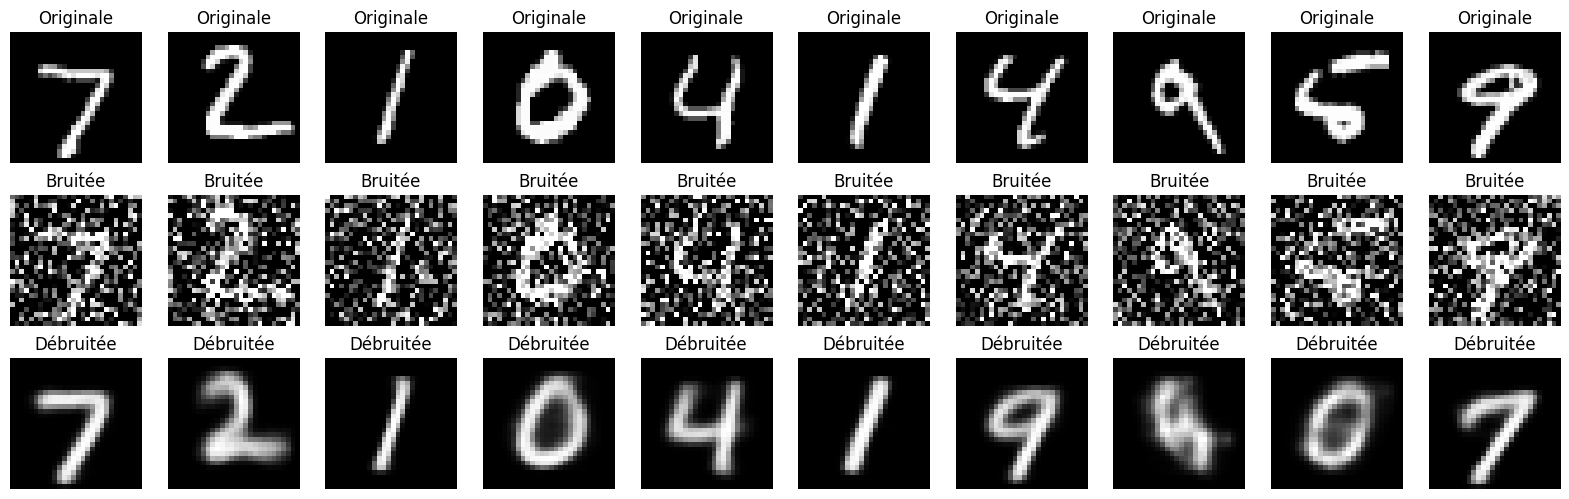

In [ ]:
import matplotlib.pyplot as plt

# Images originales, bruitées et débruitées
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 6))

for i in range(n):
    # Images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Originale")
    plt.axis('off')

    # Images bruitées
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Bruitée")
    plt.axis('off')

    # Images débruitées
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Débruitée")
    plt.axis('off')

plt.show()


In [ ]:
autoencoder.save('/content/drive/MyDrive/Master2/MLCI/MLCI TP4/tp_autoencoder_BGaussien.h5')
save_model(autoencoder, '/content/drive/MyDrive/Master2/MLCI/MLCI TP4/tp_autoencoder_BGaussien.keras')

In [ ]:
x_train_noisy = Bruit_Gaussien(x_train)
x_train_noisy = Bruit_SP(x_train_noisy)
x_train_noisy = Bruit_Poisson(x_train_noisy)
x_train_noisy = Bruit_Speckle(x_train_noisy)
x_test_noisy = Bruit_Gaussien(x_test)
x_test_noisy = Bruit_SP(x_test_noisy)
x_test_noisy = Bruit_Poisson(x_test_noisy)
x_test_noisy = Bruit_Speckle(x_test_noisy)

# Shuffle des données
from sklearn.utils import shuffle
x_train_noisy, x_train = shuffle(x_train_noisy, x_train)

In [ ]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 212ms/step - loss: 0.3176 - val_loss: 0.2086
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 203ms/step - loss: 0.1995 - val_loss: 0.1770
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 201ms/step - loss: 0.1728 - val_loss: 0.1632
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 94s 200ms/step - loss: 0.1620 - val_loss: 0.1583
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 200ms/step - loss: 0.1573 - val_loss: 0.1556
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 203ms/step - loss: 0.1546 - val_loss: 0.1524
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 203ms/step - loss: 0.1523 - val_loss: 0.1520
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 201ms/step - loss: 0.1508 - val_loss: 0.1510
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 202ms/step - loss: 0.1496 - val_loss: 0.1498
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 95s 202ms/step - loss: 0.1484 - val_loss: 0.1489
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 199ms/step - loss: 0.1476 - val_loss: 0.1485
Epoch 12/3

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


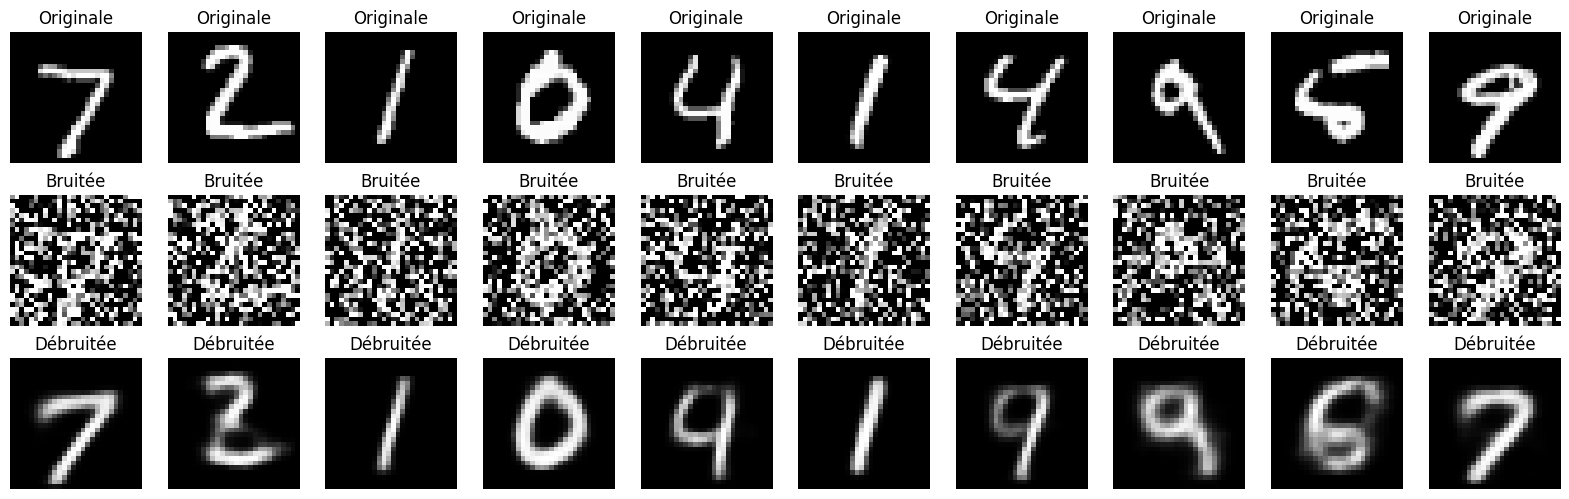

In [ ]:
import matplotlib.pyplot as plt

# Images originales, bruitées et débruitées
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10  # Nombre d'images à afficher
plt.figure(figsize=(20, 6))

for i in range(n):
    # Images originales
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Originale")
    plt.axis('off')

    # Images bruitées
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Bruitée")
    plt.axis('off')

    # Images débruitées
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Débruitée")
    plt.axis('off')

plt.show()


In [ ]:
autoencoder.save('/content/drive/MyDrive/Master2/MLCI/MLCI TP4/tp_autoencoder_all_B.h5')
save_model(autoencoder, '/content/drive/MyDrive/Master2/MLCI/MLCI TP4/tp_autoencoder_all_B.keras')